In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from scipy.stats import norm

from cnp.data import GPGenerator

from cnp.cnp import StandardConvGNP
from cnp.cov import InnerProdCov, MeanFieldCov, AddNoNoise, AddHomoNoise

import stheno

import matplotlib
matplotlib.rcParams['text.usetex'] = True

In [3]:
plot_grid_res = 1000
num_samples = 50
xmin = -4.5
xmax = 4.5
ymin = -5
ymax = 5
num_basis_dim = 512

/Users/stratis/repos/kernelcnp/venv-gnp/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
kernel = stheno.EQ().stretch(1.)
std_noise = 1e-1

gen_params = {
    'batch_size'                : 1,
    'x_context_ranges'          : [[-3., 3.]],
    'max_num_context'           : 3,
    'min_num_target'            : 3,
    'max_num_target'            : 10,
    'device'                    : 'cpu'
}

gen = GPGenerator(iterations_per_epoch=1,
                  kernel=kernel,
                  std_noise=std_noise,
                  **gen_params)

seed = 1

/Users/stratis/repos/kernelcnp/venv-gnp/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Mean field ConvGNP

In [5]:
inner_prod_cov = InnerProdCov(num_basis_dim=num_basis_dim)
add_homo_noise = AddHomoNoise()

innerprod_conv_gnp_path = './models/innerprod-convGNP'

model = StandardConvGNP(input_dim=1,
                        covariance=inner_prod_cov,
                        add_noise=add_homo_noise,
                        num_noise_channels=0)

model.load_state_dict(torch.load(innerprod_conv_gnp_path, map_location=torch.device('cpu'))['state_dict'])


np.random.seed(seed)
torch.manual_seed(seed)

data = list(gen)[0]

x_context = data['x_context']
x_target = data['x_target']
y_context = data['y_context']
y_target = data['y_target']

x_plot = torch.linspace(xmin, xmax, plot_grid_res)[None, :, None]
x_plot_rep = x_plot[:, :, 0].repeat(num_samples, 1)
x_plot = x_plot.repeat(x_context.shape[0], 1, 1)

model_output = model(x_context, y_context, x_plot)
mean, cov, cov_plus_noise = [v.detach().numpy() for v in model_output]

/Users/stratis/repos/kernelcnp/venv-gnp/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Users/stratis/repos/kernelcnp/venv-gnp/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(1000, 1) (1000, 10000)


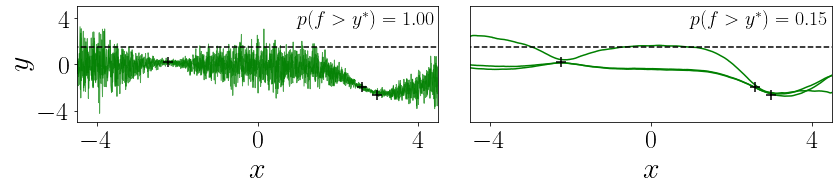

In [14]:
num_samples = 10000
plot_samples = 3

model_output = model(x_context, y_context, x_plot)
mean_pred, cov_pred, _ = [v.detach().numpy() for v in model_output]

cov_corr = cov_pred[0, :, :]
cov_diag = np.diag(np.diag(cov_corr))

chol_corr = np.linalg.cholesky(cov_corr + 1e-5 * np.eye(cov_corr.shape[0]))
chol_diag = np.linalg.cholesky(cov_diag + 1e-5 * np.eye(cov_diag.shape[0]))

np.random.seed(2)
noise = np.random.randn(cov_corr.shape[0], num_samples)

print(mean_pred[0, :, :].shape, (chol_corr @ noise).shape)
samples_corr = mean_pred[0, :, :] + chol_corr @ noise
samples_diag = mean_pred[0, :, :] + chol_diag @ noise

std_dev = np.diag(cov[0]) ** 0.5

f, (ax1, ax0) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 1]}, figsize=(12, 2.75))

x_grid = np.linspace(-4, 3., 30)

thresh = 1.5

pcorr = np.any(samples_corr > thresh, axis=0)
pcorr = np.mean(pcorr)
pdiag = np.any(samples_diag > thresh, axis=0)
pdiag = np.mean(pdiag)
    
#==============================================================================
# First plot
#==============================================================================

ax0.plot(x_plot[0, :, 0],
         samples_corr[:, -plot_samples:],
         color='green',
         alpha=1.0,
         zorder=1)

ax0.scatter(x_context[0, :, 0],
            y_context[0, :, 0],
            marker='+',
            color='black',
            s=100,
            label='Context',
            zorder=2)

ax0.plot([-5., 5.], [thresh, thresh], '--', color='k')

ax0.set_xlim([xmin, xmax])
ax0.set_ylim([ymin, ymax])
ax0.set_xticks(np.linspace(-4, 4, 3))
ax0.set_yticks([])
ax0.set_xlabel('$x$', fontsize=30)
# ax0.set_ylabel('$y$', fontsize=30)
for t in ax0.xaxis.get_major_ticks():
    t.label.set_fontsize(26)
for t in ax0.yaxis.get_major_ticks():
    t.label.set_fontsize(26)
    
ax0.text(0.95, 3.5, '$p(f > y^*) = ' + f'{pcorr:.2f}' + '$', {'fontsize' : 20})
    
#==============================================================================
# Second plot
#==============================================================================

ax1.plot(x_plot[0, :, 0],
         samples_diag[:, -3:],
         color='green',
         alpha=0.7,
         linewidth=1.,
         zorder=1)

ax1.scatter(x_context[0, :, 0],
            y_context[0, :, 0],
            marker='+',
            color='black',
            s=100,
            label='Context',
            zorder=2)

ax1.plot([-5., 5.], [thresh, thresh], '--', color='k')

ax1.set_xlim([xmin, xmax])
ax1.set_ylim([ymin, ymax])
ax1.set_xticks(np.linspace(-4, 4, 3))
ax1.set_yticks(np.linspace(-4, 4, 3))
ax1.set_xlabel('$x$', fontsize=30)
ax1.set_ylabel('$y$', fontsize=30)
for t in ax1.xaxis.get_major_ticks():
    t.label.set_fontsize(26)
for t in ax1.yaxis.get_major_ticks():
    t.label.set_fontsize(26)
    
ax1.text(0.95, 3.5, '$p(f > y^*) = ' + f'{pdiag:.2f}' + '$', {'fontsize' : 20})
    
plt.tight_layout()
plt.savefig('./plots/threshold-demo.pdf')
plt.show()